# Wyszukiwanie wzorca 2D

In [1]:
import queue
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

## Implementacja automatu Aho-Corasick dla wzorca dwuwymiarowego

Automat został zbudowany w oparciu o stany definiowane przez węzły trie kolumn wzorca. Dla danych 2D automat kolumnami buduje tablicę stanów. Następnie w tej tablicy stanów, również przy pomocy automatu wyszukiwany jest wzorzec stanów terminalnych odpowiadający kolumnom wzorca.

In [2]:
class Node():
    
    def __init__(self, letter, parent = None, terminal=False):
        self.letter = letter
        self.children = []
        self.parent = parent
        self.terminal = terminal
        self.number = None
    
    def create_child(self, letter):
        child = Node(letter, parent = self)
        self.children.append(child)
        return child
    
    def child(self, letter):
        children_ = {self.children[i].letter: i for i in range(len(self.children))}
        if not letter in children_.keys():
            return None
        return self.children[children_[letter]]
    
    def __str__(self):
        return f'letter: {self.letter}\nchildren: {len(self.children)}\nterminal: {self.terminal}\n'
    
    def __repr__(self):
        return self.__str__()
    
    def get_graph(self, G):
        for child in self.children:
            G.add_edge(id(self), id(child))
            child.get_graph(G)
               
class Trie():
    def __init__(self, term_char='$'):
        self.term_char = term_char
        self.root = Node(' ')
        
        self.number_iter = None
        self.state_map = {}
        
    def add_suffix(self, text):
        node = self.root
        i = 0
        while i < len(text):
            child = node.child(text[i])
            if child:
                node = child
            else:
                break
            i+=1
        
        while i <len(text):
            node = node.create_child(text[i])
            i+=1
        
        node.terminal = True
            
    def construct(self, patterns):
        for pattern in patterns:
            self.add_suffix(pattern)
               
    def number_nodes(self):
        self.number_iter = 0
       
        q = queue.Queue()
        q.put(self.root)
        while not q.empty():
            node = q.get()
            for child in node.children:
                q.put(child)
            node.number = self.number_iter
            self.state_map[self.number_iter] = node
            self.number_iter += 1
        

In [3]:
def build_SMA(alphabet, patterns):
    trie = Trie()
    trie.construct(patterns)
    trie.number_nodes()
    terminal_states = []
    delta = [{} for i in range(trie.number_iter)]
    if trie.root.terminal:
        terminal_states.append(trie.root)
        
    for letter in alphabet:
        delta[0][letter] = 0
        
    for state in range(1, len(trie.state_map)):
        t = trie.state_map[state].parent
        a = trie.state_map[state].letter
        temp = delta[t.number][a]
        delta[t.number][a] = state
        
        if trie.state_map[temp].terminal or trie.state_map[state].terminal:
            terminal_states.append(state)
            
        for letter in alphabet:
            delta[state][letter] = delta[temp][letter]
            
        for child in trie.state_map[temp].children:
            delta[state][child.letter] = child.number
            
    order = []
    for pattern in patterns:
        order.append(get_automata_steps(pattern, delta)[-1])
        
    small_delta, small_terminal = build_small_SMA(np.arange(len(delta)), np.array(order))
            
    return delta, terminal_states, small_delta, small_terminal

def build_small_SMA(alphabet, pattern):
    delta = [{}]
    for letter in alphabet:
        delta[0][letter] = 0
    terminal = 0
    for pattern_letter in pattern:
        temp = delta[terminal][pattern_letter]
        delta.append({})
        delta[terminal][pattern_letter] = terminal + 1
        terminal = terminal +1
        for letter in alphabet:
            delta[terminal][letter] = delta[temp][letter]
            
    return delta, terminal

def get_automata_steps(text_line, delta):
    output = []
    state = 0
    for letter in text_line:
        state = delta[state][letter]
        output.append(state)

    return np.array(output)
        
        
def apply_automata(text, delta):
    rows, columns = text.shape
    state_array = []
    
    for c in range(columns):
        state_array.append(get_automata_steps(text[:,c], delta))
        
    return np.array(state_array).T

def naive(text, pattern):
    ans = []
    m = len(pattern)
    n = len(text)
    for i in range(n-m+1):
        if np.array_equal(text[i:i+m], pattern):
            ans.append(i)
    return ans    
    
def find_pattern(text, pattern, delta, small_delta, terminal):

    locations = []
    pattern_array = apply_automata(text, delta)

    for row_id in range(len(pattern_array)):
        state = 0
        for col_id in range(len(pattern_array[row_id])):
            state = small_delta[state][pattern_array[row_id][col_id]]
            if state == terminal:
                locations.append((row_id, col_id))
    
    return locations
    

In [4]:
toy_example_pattern = np.array([['a', 'a', 'a'],
                                ['b', 'b', 'a'],
                                ['a', 'a', 'b']])

toy_example_text = np.array([['a', 'b', 'a', 'b', 'a', 'b', 'b'],
                             ['a', 'a', 'a', 'a', 'b', 'b', 'b'],
                             ['b', 'b', 'b', 'a', 'a', 'a', 'b'],
                             ['a', 'a', 'a', 'b', 'b', 'a', 'a'],
                             ['b', 'b', 'a', 'a', 'a', 'b', 'b'],
                             ['a', 'a', 'b', 'a', 'a', 'a', 'a']])

delta, T, small_delta, small_terminal = build_SMA('ab', ['aba', 'aba', 'aab'])

find_pattern(toy_example_text, toy_example_pattern, delta, small_delta, small_terminal)

[(3, 3), (4, 5), (5, 2)]

## Testowanie działania

### Szukanie wzorca w tekście

In [5]:
with open('haystack.txt') as f:
    data = f.read()

data = np.array([list(line) for line in data.split('\n')])
lens = np.array([len(i) for i in data])
mask = np.arange(lens.max()) < lens[:,None]
text = np.full(mask.shape, '_')
text[mask] = np.concatenate(data)

alphabet = np.unique(text)

In [6]:
def show_findings(alphabet, text, pattern, where=True):
    delta, T, small_delta, small_terminal = build_SMA(alphabet, [pattern[:, c] for c in range(pattern.shape[1])])
    positions = find_pattern(text, pattern, delta, small_delta, small_terminal)
    if len(positions)>0:
        if where:
            print(f'Pattern: \n{pattern}\nwas found here:\n{positions}\nThats {len(positions)} times')
        else:
            print(f'Pattern: \n{pattern}\nwas found {len(positions)} times')
        print('--------------')
    else:
        print(f'Pattern: \n{pattern}\nnotfound')
        print('--------------')

#### Wzorce typu jedna litera w dwóch kolejnych wierszach na tym samym miejscu

In [7]:
one_letter_patterns = [np.array([[letter], [letter]]) for letter in alphabet if not letter=='_' ]

for pattern in one_letter_patterns:
    show_findings(alphabet, text, pattern)

Pattern: 
[[' ']
 [' ']]
was found here:
[(1, 10), (1, 27), (1, 58), (1, 73), (2, 2), (2, 10), (2, 34), (3, 2), (4, 41), (4, 44), (5, 7), (5, 64), (6, 7), (6, 9), (6, 45), (7, 45), (9, 25), (10, 48), (11, 7), (11, 11), (14, 60), (15, 58), (16, 11), (16, 58), (19, 32), (20, 3), (21, 3), (21, 11), (21, 39), (21, 51), (21, 76), (22, 49), (22, 51), (22, 59), (22, 69), (23, 13), (23, 20), (23, 22), (23, 30), (23, 42), (23, 77), (24, 20), (24, 24), (24, 38), (24, 58), (24, 60), (25, 8), (25, 16), (25, 20), (25, 24), (25, 44), (25, 63), (28, 1), (28, 3), (28, 5), (29, 3), (29, 66), (31, 23), (31, 29), (31, 51), (31, 57), (32, 15), (32, 55), (33, 15), (33, 17), (33, 19), (33, 72), (34, 8), (34, 44), (35, 69), (36, 33), (36, 64), (38, 1), (38, 3), (38, 5), (38, 7), (38, 26), (38, 63), (39, 7), (41, 8), (41, 15), (41, 46), (41, 69), (42, 15), (42, 33), (42, 62), (43, 33), (43, 68), (44, 35), (45, 13), (45, 35), (45, 61), (46, 20), (46, 32), (47, 12), (47, 32), (47, 58), (47, 75), (48, 23), (48, 

#### Wzorce typu 'th' i 't h' w dwóch kolejnych wierszach na tym samym miejscu

In [8]:
th_pattern = np.array([['t', 'h'], ['t', 'h']])
t_h_pattern = np.array([['t', ' ', 'h'], ['t', ' ', 'h']])

show_findings(alphabet, text, th_pattern)
show_findings(alphabet, text, t_h_pattern)

Pattern: 
[['t' 'h']
 ['t' 'h']]
notfound
--------------
Pattern: 
[['t' ' ' 'h']
 ['t' ' ' 'h']]
was found here:
[(38, 2)]
Thats 1 times
--------------


### Szukanie wzorca w obrazie

#### Pojedyńcze litery

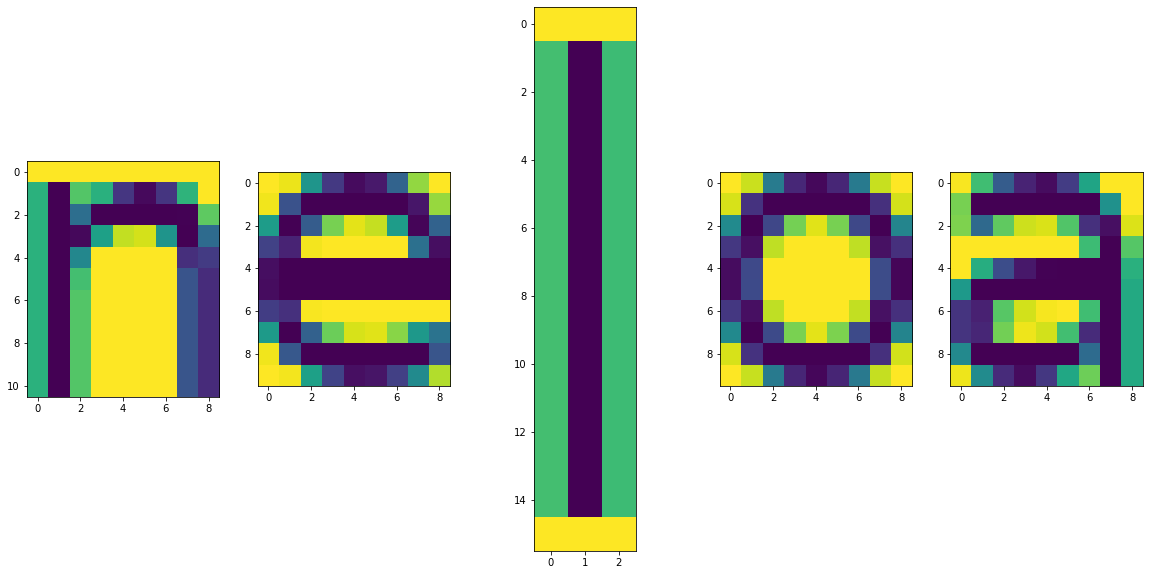

In [9]:
data = np.array(Image.open('haystack.png').convert('L'))
alphabet = np.unique(data)

n_pattern = data[36:47,40:49] #339
e_pattern = data[37:47,51:60] #
l_pattern = data[32:48,169:172]
o_pattern = data[59:69,26:35] #398
a_pattern = data[103:113,56:65] #397

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(n_pattern)
ax[1].imshow(e_pattern)
ax[2].imshow(l_pattern)
ax[3].imshow(o_pattern)
ax[4].imshow(a_pattern)

#print(f'Alphabet: {alphabet}')
in_text = Counter(text.flatten().tolist()) #to check correctness

In [10]:
show_findings(alphabet, data, n_pattern, where=False)
print(f'It appeared in the text {in_text["n"]} times')

Pattern: 
[[255 255 255 255 255 255 255 255 255]
 [163   0 187 162  40   6  39 166 255]
 [163   0  92   0   0   0   0   1 192]
 [163   0   5 145 232 239 132   0  89]
 [163   0 118 255 255 255 255  34  44]
 [163   0 179 255 255 255 255  66  32]
 [163   0 187 255 255 255 255  67  31]
 [163   0 187 255 255 255 255  67  31]
 [163   0 187 255 255 255 255  67  31]
 [163   0 187 255 255 255 255  67  31]
 [163   0 187 255 255 255 255  67  31]]
was found 339 times
--------------
It appeared in the text 339 times


In [11]:
show_findings(alphabet, data, e_pattern, where=False)
print(f'It appeared in the text {in_text["e"]} times')

Pattern: 
[[255 248 133  42   7  17  81 214 255]
 [250  64   0   0   0   0   0  15 216]
 [141   0  74 203 245 233 141   3  80]
 [ 50  25 251 255 255 255 255  94   9]
 [  9   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0]
 [ 46  35 253 255 255 255 255 255 255]
 [139   0  79 198 240 244 210 136  97]
 [250  70   0   0   0   0   0   0  67]
 [255 251 145  51  10  14  48 122 226]]
was found 576 times
--------------
It appeared in the text 583 times


In [12]:
show_findings(alphabet, data, l_pattern, where=False)
print(f'It appeared in the text {in_text["l"]} times')

Pattern: 
[[255 255 255]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [179   0 175]
 [255 255 255]]
was found 173 times
--------------
It appeared in the text 175 times


In [13]:
show_findings(alphabet, data, o_pattern, where=False)
print(f'It appeared in the text {in_text["o"]} times')

Pattern: 
[[255 235 106  28   5  27 104 234 255]
 [240  37   0   0   0   0   0  35 239]
 [122   0  54 202 244 203  55   0 116]
 [ 41  10 231 255 255 255 231  11  35]
 [  8  56 255 255 255 255 255  59   3]
 [  8  57 255 255 255 255 255  59   3]
 [ 41  10 231 255 255 255 232  11  35]
 [121   0  57 204 245 205  57   0 115]
 [240  37   0   0   0   0   0  35 238]
 [255 234 105  27   4  26 103 233 255]]
was found 369 times
--------------
It appeared in the text 369 times


In [14]:
show_findings(alphabet, data, a_pattern, where=False)
print(f'It appeared in the text {in_text["a"]} times')

Pattern: 
[[253 177  74  25   8  45 149 255 255]
 [203   0   0   0   0   0   0 129 255]
 [206  87 193 236 241 186  35  10 242]
 [255 255 255 255 255 255 175   0 188]
 [255 159  60  16   1   0   0   0 162]
 [138   0   0   0   0   0   0   0 155]
 [ 38  23 189 238 252 255 177   0 155]
 [ 38  27 201 249 238 178  31   0 155]
 [120   0   0   0   0   0  89   0 155]
 [249 123  31   7  41 152 199   0 155]]
was found 397 times
--------------
It appeared in the text 397 times


#### Wzorzec 'p a t t e r n'

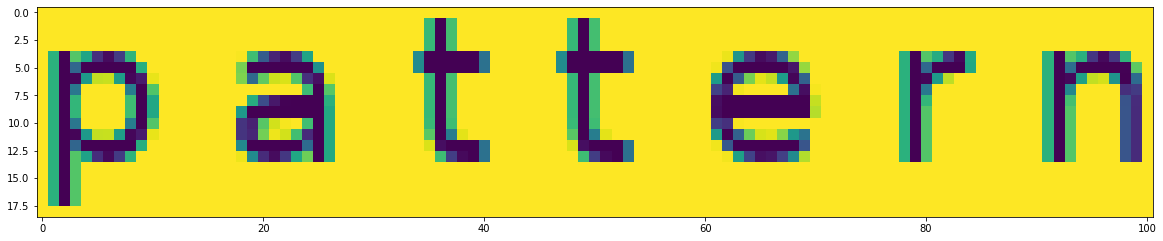

In [15]:
pattern_pattern = data[627:646,247:348]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(pattern_pattern)

In [16]:
show_findings(alphabet, data, pattern_pattern)

Pattern: 
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 163   0 ... 255 255 255]
 [255 163   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
was found here:
[(491, 283), (513, 527), (557, 341), (601, 241), (645, 347)]
Thats 5 times
--------------


### Pomiary czasu wykonania

#### Porównanie czasu budowania automatu i wyszukiwania dla różnych rozmirów wzorca

First pattern size: (11, 9)
Second pattern size: (19, 101)
Third pattern size: (200, 100)


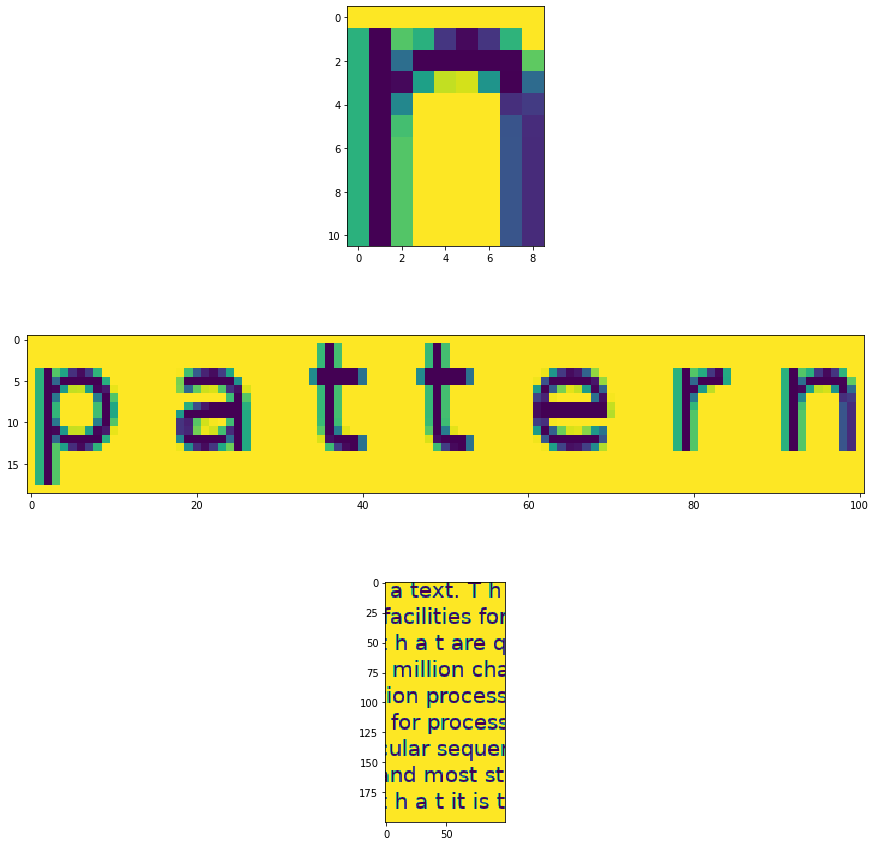

In [18]:
randomly_cut_pattern = data[100:300, 100:200]
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].imshow(n_pattern)
ax[1].imshow(pattern_pattern)
ax[2].imshow(randomly_cut_pattern)

print(f'First pattern size: {n_pattern.shape}')
print(f'Second pattern size: {pattern_pattern.shape}') 
print(f'Third pattern size: {randomly_cut_pattern.shape}')

In [19]:
%timeit build_SMA(alphabet, [n_pattern[:, c] for c in range(n_pattern.shape[1])])
delta, T, small_delta, small_terminal = build_SMA(alphabet, [n_pattern[:, c] for c in range(n_pattern.shape[1])])

8.09 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit find_pattern(data, n_pattern, delta, small_delta, small_terminal)

1.47 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit build_SMA(alphabet, [pattern_pattern[:, c] for c in range(pattern_pattern.shape[1])])
delta, T, small_delta, small_terminal = build_SMA(alphabet, [pattern_pattern[:, c] for c in range(pattern_pattern.shape[1])])

87 ms ± 9.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit find_pattern(data, pattern_pattern, delta, small_delta, small_terminal)

1.71 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit build_SMA(alphabet, [randomly_cut_pattern[:, c] for c in range(randomly_cut_pattern.shape[1])])
delta, T, small_delta, small_terminal = build_SMA(alphabet, [randomly_cut_pattern[:, c] for c in range(randomly_cut_pattern.shape[1])])

2.25 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit find_pattern(data, randomly_cut_pattern, delta, small_delta, small_terminal)

1.43 s ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Można zaobserwować liniowy wzrost czasu konstrukcji automatu w zależności od rozmiaru wzorca. Zgadza się to z teoretycznym przewidywaniem, które mówi, że złożoność obliczeniowa dana jest wzorem $O(|trie| \cdot |alfabet|)$, gdzie trie może osiągnąć nawet rozmiar całego wzorca.

Czas przeszukiwania praktycznie nie zależy od rozmiaru wzorca. Powinien zależeć jedynie od rozmiaru przeszukiwanych danych.

#### Porównanie czasu wyszukiwania dla podzielonego obrazu

In [26]:
delta, T, small_delta, small_terminal = build_SMA(alphabet, [pattern_pattern[:, c] for c in range(pattern_pattern.shape[1])])

In [27]:
%%timeit 
find_pattern(data, pattern_pattern, delta, small_delta, small_terminal)

1.38 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
delta_size = len(data)//2

In [29]:
%%timeit
for i in range(2):
    find_pattern(data[i*delta_size:(i+1)*delta_size], pattern_pattern, delta, small_delta, small_terminal)

1.43 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
delta_size = len(data)//4

In [31]:
%%timeit
for i in range(4):
    find_pattern(data[i*delta_size:(i+1)*delta_size], pattern_pattern, delta, small_delta, small_terminal)

1.35 s ± 7.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
delta_size = len(data)//8

In [33]:
%%timeit
for i in range(8):
    find_pattern(data[i*delta_size:(i+1)*delta_size], pattern_pattern, delta, small_delta, small_terminal)

1.34 s ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Otrzymane wyniki sugerują, że czas przeszukiwania jest faktycznie liniowy w zależności od długości przeszukiwanych danych.